출처: [https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)

# How to automatically create machine learning features

machine learning은 hand-designed 모델에서 H20, TPOT 및 auto-sklearn과 같은 도구를 사용하여 자동으로 최적화하는 파이프라인으로 이동하고 있습니다. 이러한 라이브러리는 random search와 같은 방법과 함께 개입이 거의 또는 전혀 없이 데이터 세트에 대한 최상의 모델을 찾아 machine learning의 일부를 조정하고 모델 선택을 단순화하는 것을 목표로 합니다. 그러나 머신 러닝 파이프라인에서 틀림없이 더 가치 있는 feature engineering은 거의 전적으로 사람의 몫으로 남아 있습니다.

feature creation이라고도 하는 feature engineering은 기존 데이터에서 새로운 feature을 구성하여 machine learning model을 훈련시키는 프로세스입니다. machine learning 알고리즘은 우리가 제공한 데이터에서만 학습하고 task와 관련된 feature을 생성하는 것이 절대적으로 중요하기 때문에 이 단계는 사용된 실제 모델보다 더 중요할 수 있습니다.

일반적으로 feature engineering은 도메인 지식, 직관 및 데이터 조작에 의존하는 수동 프로세스입니다. 이 프로세스는 매우 지루할 수 있으며 최종 feature는 인간의 주관성과 시간 모두에 의해 제한됩니다. Automated feature engineering은 data scientist를 돕기 위해 데이터 세트에서 많은 candidate features을 자동으로 생성하여 학습에 가장 적합한 feature을 선택하고 사용할 수 있도록 하는 것을 목표로 합니다.

이 아티클에서는 featuretools Python 라이브러리와 함께 automated feature engineering을 사용하는 예를 살펴보겠습니다.

# Feature Engineering Basics
feture engineering은 종종 여러 관련 테이블에 분산되어 있는 기존 데이터에서 추가 feature을 구축하는 것을 의미합니다. feature engineering은 데이터에서 관련 정보를 추출하고 이를 단일 테이블로 가져와 machine learning model을 훈련하는 데 사용할 수 있어야 합니다.

feature을 구성하는 프로세스는 특히 두 개 이상의 테이블에서 정보를 사용할 때 각각의 새 feature을 빌드하는 데 여러 단계가 필요하기 때문에 시간이 많이 걸립니다. feature 생성 작업을 **transformations**와 **aggregations**라는 두 가지 범주로 그룹화할 수 있습니다. 이러한 개념이 실제로 작동하는지 보기 위해 몇 가지 예를 살펴보겠습니다.

**transformation**은 하나 이상의 기존 칼럼에서 새로운 feature을 생성하여 단일 테이블에서 작동합니다 (Python의 관점에서 테이블은 Pandas``` DataFrame```일 뿐입니다). 예를 들어, 아래에 clients 테이블이 있는 경우

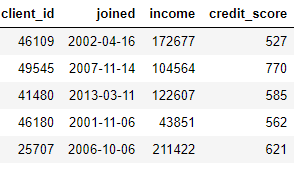

```joined``` 칼럼의 달(month)을 찾거나 ```income``` 칼럼의 자연 로그를 취하여 feature을 만들 수 있습니다. 둘 다 한 테이블의 정보만 사용하기 때문에 transformations입니다.

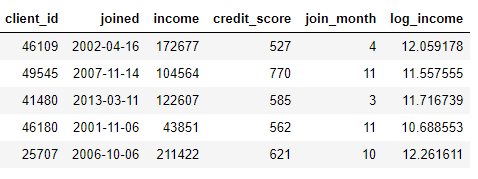

반면 aggregations는 여러 테이블에서 수행되며 one-to-many 관계를 사용하여 observations을 그룹화한 다음 통계를 계산합니다. 예를 들어, 각 고객이 여러 대출을 가질 수 있는 고객의 대출에 대한 정보가 있는 다른 테이블이 있는 경우, 각 고객에 대한 평균, 최대 및 최소 대출과 같은 통계를 계산할 수 있습니다.

이 프로세스에는 client 별로 대출 테이블을 그룹화하고 aggregations를 계산한 다음 결과 데이터를 client 데이터에 병합하는 작업이 포함됩니다. Pandas의 언어를 사용하여 Python에서 이를 수행하는 방법은 다음과 같습니다.

In [1]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/WillKoehrsen/automated-feature-engineering/master/walk_through/data/clients.csv", 
                           filename="clients.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/WillKoehrsen/automated-feature-engineering/master/walk_through/data/loans.csv", 
                           filename="loans.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/WillKoehrsen/automated-feature-engineering/master/walk_through/data/payments.csv", 
                           filename="payments.csv")

('payments.csv', <http.client.HTTPMessage at 0x2a9ea0fa220>)

In [2]:
clients = pd.read_csv('clients.csv', parse_dates=['joined'])
loans = pd.read_csv('loans.csv', parse_dates=['loan_start', 'loan_end'])
payments = pd.read_csv('payments.csv', parse_dates=['payment_date'])

In [3]:
print(clients.shape)
clients.head()

(25, 4)


,client_id,joined,income,credit_score
0,46109,2002-04-16,172677,527
1,49545,2007-11-14,104564,770
2,41480,2013-03-11,122607,585
3,46180,2001-11-06,43851,562
4,25707,2006-10-06,211422,621


In [4]:
clients["client_id"].value_counts()

46109    1
29841    1
49624    1
41472    1
46958    1
38537    1
26695    1
39384    1
44387    1
49068    1
32885    1
44601    1
32961    1
49545    1
42320    1
26326    1
48177    1
35214    1
35089    1
32726    1
39505    1
25707    1
46180    1
41480    1
26945    1
Name: client_id, dtype: int64

In [5]:
loans.sample(5)

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
60,46180,home,3022,0,11204,2003-11-22,2005-05-18,8.39
186,48177,other,7813,1,10073,2012-05-10,2014-07-17,2.14
85,25707,credit,5200,1,10205,2010-02-27,2012-07-08,5.72
285,32885,cash,9646,0,10300,2007-12-13,2009-07-12,0.47
393,46958,credit,13187,0,11618,2010-10-10,2013-06-22,1.96


In [6]:
loans["client_id"].value_counts()

46109    20
41480    20
46180    20
25707    20
39505    20
35089    20
49545    20
44601    20
32726    19
48177    19
39384    19
49068    18
35214    18
26695    18
29841    18
38537    17
32961    17
26326    16
41472    16
44387    15
32885    15
42320    15
49624    15
26945    15
46958    13
Name: client_id, dtype: int64

In [7]:
payments.sample(5)

,loan_id,payment_amount,payment_date,missed
2390,11183,554,2013-07-07,1
441,11553,1078,2001-03-29,0
2230,10024,697,2005-11-04,1
836,11573,1101,2003-12-21,0
190,10192,536,2013-06-28,1


In [8]:
import pandas as pd

stats = loans.groupby("client_id")["loan_amount"].agg(["mean", "max", "min"])
stats.columns = ["mean_loan_amount", "max_loan_amount", "min_loan_amount"]

stats = clients.merge(stats, left_on="client_id", right_index=True, how="left")
stats.head()

,client_id,joined,income,credit_score,mean_loan_amount,max_loan_amount,min_loan_amount
0,46109,2002-04-16,172677,527,8951.60,14049,559
1,49545,2007-11-14,104564,770,10289.30,14971,3851
2,41480,2013-03-11,122607,585,7894.85,14399,811
3,46180,2001-11-06,43851,562,7700.85,14081,1607
4,25707,2006-10-06,211422,621,7963.95,13913,1212


이러한 작업 자체는 어렵지 않지만 수십 개의 테이블에 수백 개의 변수가 분산되어 있는 경우 이 프로세스를 수동으로 수행할 수 없습니다. 이상적으로는 여러 테이블에서 transformations 및 aggregations를 자동으로 수행하고 resulting data를 단일 테이블로 결합할 수 있는 솔루션이 필요합니다.

# Featuretools
다행히도 featuretools가 바로 우리가 찾고 있는 솔루션입니다. 이 오픈 소스 Python 라이브러리는 관련 테이블 세트에서 많은 feature을 자동으로 생성합니다. Featuretools는 ["Deep Feature Synthesis"](https://haje01.github.io/2019/12/27/deep-feature-synthesis.html)로 알려진 방법을 기반으로 합니다. 이 방법은 실제보다 훨씬 더 인상적입니다(딥 러닝을 사용하기 때문이 아니라 여러 기능을 쌓아서 이름이 유래)

Deep feature synthesis는 여러 테이블에 걸쳐 분산된 데이터에서 feature을 생성하기 위해 여러 transformation 및 aggregation 작업(featuretools의 용어로 feature primitives라고 한다)을 쌓습니다. machine learning의 대부분의 아이디어와 마찬가지로 간단한 개념을 기반으로 구축된 복잡한 방법입니다. 한 번에 하나의 빌딩 블록을 학습함으로써 우리는 이 강력한 방법을 잘 이해할 수 있습니다.

먼저 예제 데이터를 살펴보겠습니다. 위의 데이터 세트 중 일부를 이미 보았고 전체 테이블 컬렉션은 다음과 같습니다:

<br/>

- ```clients```: credit unioin에서 고객들에 대한 기본 정보. 각 고객은 이 데이터프레임에서 하나의 행을 가집니다.

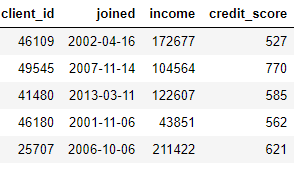

- ```loans```: 고객에 대한 대출. 각 대출은 이 데이터 프레임에 하나의 행만 있지만 고객은 여러 대출을 가질 수 있습니다.

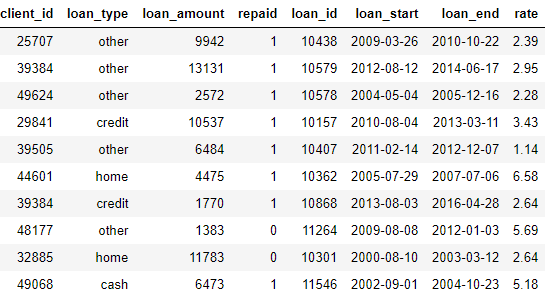

- ```payments```: 대출에 대한 payments. 각 payments에는 행이 하나만 있지만 각 대출에는 여러 payments가 있습니다.

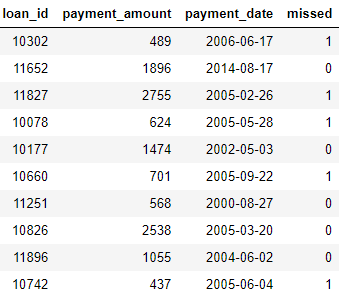

고객이 향후 대출을 상환할지 여부를 예측하는 것과 같은 machine learning 작업이 있는 경우 고객에 대한 모든 정보를 단일 테이블로 결합하고자 할 것입니다. 테이블은 관련되어 있으며(```client_id``` 및 ```loan_id``` 변수를 통해) 일련의 transformations 및 aggregations를 사용하여 이 프로세스를 직접 수행할 수 있습니다. 그러나 곧 featuretools를 사용하여 프로세스를 자동화할 수 있음을 알게 될 것입니다.

# Entities and EntitySets
featuretools의 처음 두 개념은 **entities**와 **entitysets**입니다. entity는 단순한 테이블(또는 Pandas에서 생각하는 경우 DataFrame)입니다. EntitySet은 테이블과 테이블 간의 관계 collection입니다. entityset을 고유한 methods와 attributes가 있는 또 다른 Python 데이터 구조로 생각하십시오.

우리는 다음을 통해 featuretools에서 빈 entityset을 만들 수 있습니다:

In [9]:
import featuretools as ft

# 새로운 entityset 만들기
es = ft.EntitySet(id="clients")

이제 entities를 추가해야 합니다. 각 entity에는 고유한 elements가 모두 포함된 칼럼인 인덱스가 있어야 합니다. 즉, 인덱스의 각 값은 테이블에 한 번만 나타나야 합니다. ```clients``` 데이터 프레임의 인덱스는 ```client_id```입니다. 왜냐하면 각 고객은 이 데이터 프레임에 하나의 행만 있기 때문입니다. 다음 syntax을 사용하여 기존 인덱스가 있는 entity를 entityset에 추가합니다:

In [10]:
es = es.add_dataframe(dataframe_name="clients", dataframe=clients,
                      index="client_id", time_index="joined")

```loans``` 데이터 프레임에는 또한 고유 인덱스인 ```loan_id```가 있으며 이를 entityset에 추가하는 syntax은 ```clients```의 경우와 동일합니다. 그러나 ```payments``` 데이터 프레임에는 고유 인덱스가 없습니다. 이 entity를 entityset에 추가할 때 ```make_index=True``` parameter를 전달하고 인덱스 이름을 지정해야 합니다. 또한 featuretools가 entity의 각 칼럼 데이터 유형을 자동으로 유추하지만 칼럼 유형 dictionary를 parameter ```variable_types```에 전달하여 이를 재정의할 수 있습니다.

In [11]:
from woodwork.logical_types import Categorical

es = es.add_dataframe(dataframe_name="payments", dataframe=payments,
                      logical_types={"missed": Categorical},
                      make_index=True,
                      index="payment_id",
                      time_index="payment_date")

이 데이터 프레임의 경우 ```missed```는 정수이지만 2개의 이산 값만 사용할 수 있으므로 numeirc 변수가 아니기 때문에 featuretools에게 categorical 변수로 처리하도록 지시합니다. entityset에 데이터 프레임을 추가한 후 다음 중 하나를 점검합니다:

In [12]:
es["payments"]["missed"].dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [13]:
es = es.add_dataframe(dataframe_name="loans", dataframe=loans,
                      logical_types={"repaid": Categorical},
                      index="loan_id",
                      time_index="loan_start")

In [14]:
es["loans"]["repaid"].dtype

CategoricalDtype(categories=[0, 1], ordered=False)

column types는 우리가 지정한 대로 올바르게 추론되었습니다. 다음으로 entityset의 테이블이 어떻게 연관이 있는지 지정해야 합니다.

# Table Relationships
두 테이블 간의 관계를 생각하는 가장 좋은 방법은 [parent to child 비유](https://stackoverflow.com/questions/7880921/what-is-a-parent-table-and-a-child-table-in-database)입니다(one-to-many 관계). 각 parent는 여러 child를 가질 수 있습니다. 테이블 영역에서 parent 테이블에는 모든 parent에 대해 하나의 행이 있지만 child 테이블에는 동일한 parent의 여러 child에 해당하는 여러 행이 있을 수 있습니다.

예를 들어, 데이터 세트에서 ```clients``` 데이터 프레임은 ```loans``` 데이터 프레임의 parent입니다. 각 client는 ```clients```에 행이 하나만 있지만 ```loans```에는 여러 행이 있을 수 있습니다. 마찬가지로, 각 ```loans```는 여러 번 지불해야 하므로 대출은 ```payments```의 parent입니다. parent는 공유 변수에 의해 child과 연결됩니다. aggregations를 수행할 때 parent 변수별로 child 테이블을 그룹화하고 각 parent의 child에 대한 통계를 계산합니다.

featuretools에서 관계를 공식화하려면, 두 테이블을 함께 연결하는 변수만 지정하면 됩니다. ```clients```와 ```loans``` 테이블은 ```client_id``` 변수를 통해 연결되고 ```loans``` 및 ```payments```은 ```loan_id```와 연결됩니다. 관계를 만들고 entityset에 추가하는 syntax는 다음과 같습니다.

In [15]:
# Relationship between clients and previous loans
r_client_previous = ft.Relationship(es, "clients", "client_id", "loans", "client_id")

# entityset에 관계 추가
es = es.add_relationship(relationship=r_client_previous)

# Relationship between previous loans and previous payments
r_payments = ft.Relationship(es, "loans", "loan_id", "payments", "loan_id")

# entityset에 관계 추가
es = es.add_relationship(relationship=r_payments)

In [16]:
es

Entityset: clients
  DataFrames:
    clients [Rows: 25, Columns: 4]
    payments [Rows: 3456, Columns: 5]
    loans [Rows: 443, Columns: 8]
  Relationships:
    loans.client_id -> clients.client_id
    payments.loan_id -> loans.loan_id

이제 entityset에는 세 개의 entity(테이블)와 이러한 entity를 함께 연결하는 관계가 포함됩니다. entity를 추가하고 관계를 공식화하면 entityset이 완성되고 feature을 만들 준비가 되었습니다.

# Feature Primitives
deep feature synthesis에 도달하기 전에, 우리는 featue primitives를 이해해야 합니다. 우리는 이것이 무엇인지 이미 알고 있지만, 다른 이름으로 부르고 있습니다. 다음은 새로운 feature을 형성하는 데 사용하는 단순한 기본 작업입니다:

<br/>

- Aggregations: parent를 기준으로 그룹화하고 child에 대한 통계를 계산하는 parent-child(one-to-many) 관계에서 완료된 작업입니다. 예를 들어 ```loan``` 테이블을 ```client_id```별로 그룹화하고 각 client의 최대 대출 금액을 찾는 것이 있습니다.

<br/>

- Transformations: 단일 테이블에서 수행된 작업을 하나 이상의 칼럼에 적용합니다. 한 테이블에 있는 두 칼럼의 차이를 취하거나 칼럼의 절대값을 취하는 것이 한 예입니다.

<br/>

이러한 primitive를 단독으로 사용하거나 여러 primitives를 쌓아서 featuretools에서 새 feature을 생성합니다. 다음은 featuretools의 일부 feature primitives 목록입니다(또한, 우리는 custom primitives를 정의할 수도 있습니다).

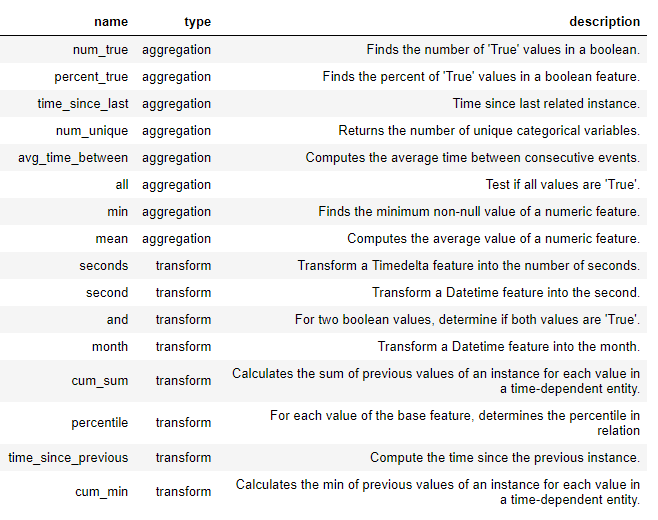

이러한 primitives는 단독으로 사용하거나 결합하여 feature을 생성할 수 있습니다. 지정된 primitives로 feature을 만들기 위해 ```ft.dfs``` 함수(deep feaeture synthesis를 나타낸다)를 사용합니다. 우리는 feature을 추가하려는 테이블인  ```entityset```과 ```target_entity```, selected ```trans_primitives``` (transformations), ```agg_primitives``` (aggregations)를 전달합니다:

In [17]:
# specified primitives를 사용하여 새로운 features 만들기
features, feature_names = ft.dfs(entityset=es, target_dataframe_name="clients",
                                 agg_primitives=["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"],
                                 trans_primitives=["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"])

결과는 각 client에 대한 새로운 feature의 데이터 프레임입니다(clients를 ```target_entity```로 만들었기 때문에). 예를 들어 transformation feature primitive인 각 client를 합친 month가 있습니다:

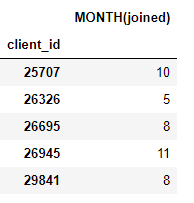

또한 각 client의 평균 지불 금액과 같은 여러 aggregation primitives가 있습니다.

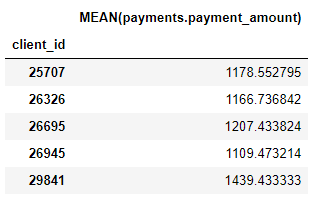

featuretools를 통해 합치고 이러한 primitives를 쌓아 많은 새로운 features를 만들었습니다.

# Deep Feature Synthesis
이제 deep feature synthesis(dfs)를 이해하기 위한 모든 부분이 준비되었습니다. 사실, 우리는 이전 함수 호출에서 이미 dfs를 수행했습니다. deep feature는 단순히 여러 primitives를 쌓아 만든 feature이며 dfs는 이러한 feature를 만드는 프로세스의 이름입니다. deep feature의 깊이는 feature를 만드는 데 필요한 primitives의 수입니다.

여기서는 우리는 원하는 depth로 features을 쌓을 수 있지만 실제로는 depth 2를 넘은 적이 없습니다. 이 depth 이후에는 feature을 해석하기가 어렵지만, 관심 있는 사람이라면 누구나 "더 깊이" 해보는 것을 권장합니다.

feature primitives를 수동으로 지정할 필요는 없지만 대신 featuretools가 자동으로 feature을 선택하도록 할 수 있습니다. 이를 위해 동일한 ```ft.dfs``` 함수를 사용하지만 feature primitives를 전달하지 않습니다.

In [22]:
features, feature_names = ft.dfs(entityset=es, target_dataframe_name="clients",
                                 max_depth=2)

features.head()

,income,credit_score,COUNT(loans),MAX(loans.loan_amount),MAX(loans.rate),MEAN(loans.loan_amount),MEAN(loans.rate),MIN(loans.loan_amount),MIN(loans.rate),MODE(loans.loan_type),...,MODE(payments.loans.loan_type),MODE(payments.loans.repaid),NUM_UNIQUE(payments.loans.loan_type),NUM_UNIQUE(payments.loans.repaid),SKEW(payments.loans.loan_amount),SKEW(payments.loans.rate),STD(payments.loans.loan_amount),STD(payments.loans.rate),SUM(payments.loans.loan_amount),SUM(payments.loans.rate)
client_id,,,,,,,,,,,,,,,,,,,,,
42320,229481,563,15,13887.0,6.74,7062.066667,2.457333,1070.0,0.38,home,...,home,1,4,2,0.097213,0.872916,3929.351652,1.891948,843367.0,302.84
39384,191204,617,19,14654.0,9.23,7865.473684,3.538421,1770.0,0.43,credit,...,cash,1,4,2,-0.277360,0.971757,3765.368569,2.685701,1161741.0,499.12
26945,214516,806,15,14593.0,5.65,7125.933333,2.855333,653.0,0.13,credit,...,credit,0,4,2,0.289824,0.020986,4372.558827,1.599556,771053.0,330.13
41472,152214,638,16,13657.0,9.82,7510.812500,3.981250,986.0,0.01,cash,...,other,1,4,2,-0.064213,0.311596,4250.127784,3.129716,784731.0,435.36
46180,43851,562,20,14081.0,9.26,7700.850000,3.502500,1607.0,0.57,other,...,other,0,4,2,0.127445,0.649145,3815.702946,2.714351,1142666.0,578.43


Featuretools는 우리가 사용할 수 있는 많은 새로운 features를 구축했습니다. 이 프로세스는 새로운 features를 자동으로 생성하지만, 이러한 모든 features로 무엇을 해야 하는지 아직 파악해야 하기 때문에 data scientist를 대체하지는 않을 것입니다. 예를 들어, 고객이 대출을 상환할지 여부를 예측하는 것이 목표인 경우 지정된 결과와 가장 상관관계가 있는 feature을 찾아야 할 수 있습니다. 또한 도메인 지식이 있는 경우, 이를 사용하여 특정 feature primitives를 선택하거나 candidate features와 함께 seed deep feature synthesis를 선택할 수 있습니다.

# Next Steps
Automated feature engineering은 한 가지 문제를 해결했지만, 또 다른 문제를 만들었습니다: 너무 많은 features. 모델을 훈련시키기 전에 이러한 features 중 어느 것이 중요할지 말하기는 어렵지만 모든 features가 모델을 훈련시키려 하는 작업과 관련이 있는 것은 아닙니다. 또한 feature이 너무 많으면 덜 유용한 feature이 더 중요한 feature을 압도하기 때문에 모델 성능이 저하될 수 있습니다.

너무 많은 feature의 문제는 curse of dimensionality로 알려져 있습니다. feature의 수가 증가함에 따라 (데이터의 차원이 증가함에 따라) 모델이 feature과 target 간의 매핑을 학습하는 것이 점점 더 어려워집니다. 실제로 모델이 잘 수행되는 데 필요한 데이터의 양은 feature의 수에 따라 기하급수적으로 확장됩니다.

curse of dimensionality는 관련 없는 feature을 제거하는 프로세스인 feature reduction(feature selection이라고도 한다)로 해결됩니다. 이는 PCA(주성분 분석), SelectKBest, 모델의 featue importances 사용 또는 deep neural networks를 사용한 auto encoding 등 다양한 형태를 취할 수 있습니다. 하지만, feature reduction은 다른 아티클을 위한 topic입니다. 따라서, 지금은 featuretools를 사용하여 최소한의 노력으로 많은 테이블에서 수많은 feature을 생성할 수 있다는 것을 아는 것에 집중합니다.

# Conclusions
Machine learning의 많은 주제와 마찬가지로 featuretools를 사용한 automated feature engineering은 단순한 아이디어를 기반으로 하는 복잡한 개념입니다. entityset, entity 및 relationship의 개념을 사용하여 featuretools는 deep feateure synthesis를 수행하여 새 feature을 생성할 수 있습니다. 차례로 deep feature synthesis은 primitives(테이블 간의 one-to-many 관계에서 작동하는 **aggregations**, 단일 테이블의 하나 이상의 칼럼에 적용되는 기능인 **transformations**)를 제공하여 여러 테이블에서 새로운 feature를 구축합니다.

featuretools에 대한 더 자세한 내용은 [online documentation](https://featuretools.alteryx.com/en/stable/)를 확인하고, featuretools가 실제로 어떻게 사용되는지 보려면 오픈 소스 라이브러리에 관한 회사인 [work of Feature Labs](https://www.alteryx.com/open-source)에 대해 읽어보세요.